In [ ]:
# Install required libraries
!pip install yfinance mplfinance

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import mplfinance as mpf
from datetime import date

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Step 1: Fetch NSE stock data using yfinance
stock_symbol = "tcs.NS"
start_date = "2024-01-01"
end_date = "2025-03-31"
try:
    # Fetch data with auto_adjust=False to ensure consistent columns
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date, auto_adjust=False)

    # Convert to DataFrame and reset index
    df = stock_data.reset_index()
    if df.empty:
        print("Error: No data fetched. DataFrame is empty.")
        raise SystemExit

    # Print raw columns for debugging
    print("Raw columns from yfinance:", df.columns.tolist())

    # Handle MultiIndex or flat columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if col[1] == '' else col[0] for col in df.columns]

    # Rename columns based on actual number of columns
    expected_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    if len(df.columns) == 6:
        # Likely ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    elif len(df.columns) == 7:
        # Likely ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        df.columns = expected_columns
        df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Drop Adj Close
    else:
        print(f"Unexpected number of columns: {len(df.columns)}")
        raise SystemExit

    print("Step 1: Data fetched successfully. First few rows:")
    print(df.head())
    print("Columns after renaming:", df.columns.tolist())
except Exception as e:
    print(f"Error fetching data: {e}")
    raise SystemExit


[*********************100%***********************]  1 of 1 completed

Raw columns from yfinance: [('Date', ''), ('Adj Close', 'TCS.NS'), ('Close', 'TCS.NS'), ('High', 'TCS.NS'), ('Low', 'TCS.NS'), ('Open', 'TCS.NS'), ('Volume', 'TCS.NS')]
Step 1: Data fetched successfully. First few rows:
        Date         Open         High          Low        Close   Volume
0 2024-01-01  3739.366455  3811.100098  3832.000000  3773.000000   825907
1 2024-01-02  3711.991699  3783.199951  3811.100098  3767.250000  1344068
2 2024-01-03  3622.263184  3691.750000  3771.850098  3687.050049  1803075
3 2024-01-04  3597.782471  3666.800049  3719.000000  3651.000000  3598144
4 2024-01-05  3667.544189  3737.899902  3747.750000  3674.850098  1963127
Columns after renaming: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


In [ ]:
# Step 2: Calculate 9-day EMA
df['EMA9'] = df['Close'].ewm(span=9, adjust=False).mean()
print("\nStep 2: Data with 9-day EMA:")
print(df[['Date', 'Close', 'EMA9']].head())
print("Columns:", df.columns.tolist())


Step 2: Data with 9-day EMA:
        Date        Close         EMA9
0 2024-01-01  3773.000000  3773.000000
1 2024-01-02  3767.250000  3771.850000
2 2024-01-03  3687.050049  3754.890010
3 2024-01-04  3651.000000  3734.112008
4 2024-01-05  3674.850098  3722.259626
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA9']


In [ ]:
# Step 3: Candlestick pattern recognition
def is_doji(open, high, low, close):
    try:
        open, high, low, close = float(open), float(high), float(low), float(close)
        body = abs(close - open)
        candle_range = high - low
        return body <= 0.1 * candle_range if candle_range > 0 else False
    except Exception as e:
        print(f"Error in is_doji: {e}")
        return False

def is_bullish_engulfing(df, i):
    if i == 0:
        return False
    try:
        prev_open = float(df['Open'].iloc[i-1])
        prev_close = float(df['Close'].iloc[i-1])
        curr_open = float(df['Open'].iloc[i])
        curr_close = float(df['Close'].iloc[i])
        return (prev_close < prev_open and
                curr_open < prev_close and
                curr_close > prev_open and
                curr_close > curr_open)
    except Exception as e:
        print(f"Error in is_bullish_engulfing at index {i}: {e}")
        return False

def is_bearish_engulfing(df, i):
    if i == 0:
        return False
    try:
        prev_open = float(df['Open'].iloc[i-1])
        prev_close = float(df['Close'].iloc[i-1])
        curr_open = float(df['Open'].iloc[i])
        curr_close = float(df['Close'].iloc[i])
        return (prev_close > prev_open and
                curr_open > prev_close and
                curr_close < prev_open and
                curr_close < curr_open)
    except Exception as e:
        print(f"Error in is_bearish_engulfing at index {i}: {e}")
        return False

# Apply candlestick pattern detection
try:
    df['Doji'] = [is_doji(df['Open'].iloc[i], df['High'].iloc[i], df['Low'].iloc[i], df['Close'].iloc[i]) for i in range(len(df))]
    df['Bullish_Engulfing'] = [is_bullish_engulfing(df, i) for i in range(len(df))]
    df['Bearish_Engulfing'] = [is_bearish_engulfing(df, i) for i in range(len(df))]
except Exception as e:
    print(f"Error applying candlestick patterns: {e}")
    raise SystemExit
print("\nStep 3: Rows with detected candlestick patterns:")
print(df[df[['Doji', 'Bullish_Engulfing', 'Bearish_Engulfing']].any(axis=1)][['Date', 'Close', 'Doji', 'Bullish_Engulfing', 'Bearish_Engulfing']])
print("Columns:", df.columns.tolist())



Step 3: Rows with detected candlestick patterns:
          Date        Close   Doji  Bullish_Engulfing  Bearish_Engulfing
50  2024-03-14  4086.000000  False              False               True
57  2024-03-26  3871.449951  False               True              False
64  2024-04-05  3960.500000  False               True              False
88  2024-05-14  3892.899902  False               True              False
118 2024-06-27  3818.100098  False              False               True
171 2024-09-12  4431.299805  False              False               True
184 2024-10-01  4242.950195  False              False               True
196 2024-10-18  4080.000000  False              False               True
199 2024-10-23  3995.149902  False              False               True
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA9', 'Doji', 'Bullish_Engulfing', 'Bearish_Engulfing']


In [ ]:
# Step 4: Generate trading signals
df['Signal'] = 'Hold'
for i in range(1, len(df)):
    try:
        close = float(df['Close'].iloc[i])
        ema9 = float(df['EMA9'].iloc[i])
        if pd.isna(close) or pd.isna(ema9):
            continue
        ema_trend = 'Bullish' if close > ema9 else 'Bearish'
        if df['Bullish_Engulfing'].iloc[i] and ema_trend == 'Bullish':
            df['Signal'].iloc[i] = 'Buy'
        elif df['Bearish_Engulfing'].iloc[i] and ema_trend == 'Bearish':
            df['Signal'].iloc[i] = 'Sell'
        elif df['Doji'].iloc[i]:
            df['Signal'].iloc[i] = 'Hold'
    except Exception as e:
        print(f"Error at index {i}: {e}")
        continue
print("\nStep 4: Recent signals:")
print(df[['Date', 'Close', 'EMA9', 'Doji', 'Bullish_Engulfing', 'Bearish_Engulfing', 'Signal']].tail(10))
print("Columns:", df.columns.tolist())


Step 4: Recent signals:
          Date        Close         EMA9   Doji  Bullish_Engulfing  \
298 2025-03-17  3477.350098  3527.399078  False              False   
299 2025-03-18  3497.699951  3521.459253  False              False   
300 2025-03-19  3462.750000  3509.717402  False              False   
301 2025-03-20  3512.000000  3510.173922  False              False   
302 2025-03-21  3465.000000  3501.139137  False              False   
303 2025-03-24  3566.600098  3514.231329  False              False   
304 2025-03-25  3638.000000  3538.985064  False              False   
305 2025-03-26  3625.850098  3556.358070  False              False   
306 2025-03-27  3610.500000  3567.186456  False              False   
307 2025-03-28  3591.899902  3572.129146  False              False   

     Bearish_Engulfing Signal  
298              False   Hold  
299              False   Hold  
300              False   Hold  
301              False   Hold  
302              False   Hold  
303         

<ipython-input-5-8cea44801b21>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Signal'].iloc[i] = 'Buy'
<ipython-input-5-8cea44801b21>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 


Step 5: DataFrame columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA9', 'Doji', 'Bullish_Engulfing', 'Bearish_Engulfing', 'Signal']
DataFrame dtypes:
 Date                 datetime64[ns]
Open                        float64
High                        float64
Low                         float64
Close                       float64
Volume                        int64
EMA9                        float64
Doji                           bool
Bullish_Engulfing              bool
Bearish_Engulfing              bool
Signal                       object
dtype: object
NaN counts in plotting columns:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
First few rows:
         Date         Open         High          Low        Close   Volume
0 2024-01-01  3739.366455  3811.100098  3832.000000  3773.000000   825907
1 2024-01-02  3711.991699  3783.199951  3811.100098  3767.250000  1344068
2 2024-01-03  3622.263184  3691.750000  3771.850098  3687.050049  1803075
3 202

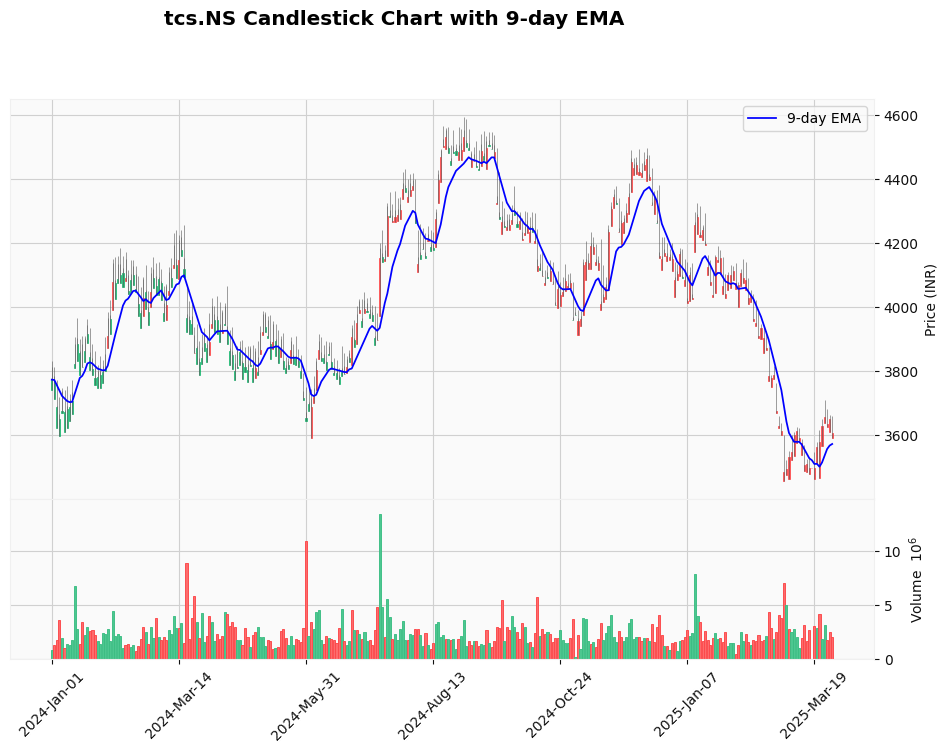


Latest Prediction for tcs.NS on 2025-03-28: Hold
🔍 HOLD/NEUTRAL signal for tcs.NS on 2025-03-28 — trend is uncertain.


In [ ]:
# Step 5: Visualize results and summarize prediction
# Verify DataFrame state
print("\nStep 5: DataFrame columns:", df.columns.tolist())
print("DataFrame dtypes:\n", df.dtypes)
print("NaN counts in plotting columns:\n", df[['Open', 'High', 'Low', 'Close', 'Volume']].isna().sum())
print("First few rows:\n", df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].head())

# Clean DataFrame: Drop rows with NaN in plotting columns
df_plot = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume', 'EMA9'])

# Ensure numeric types
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce')

# Check for any remaining NaN after type conversion
if df_plot[['Open', 'High', 'Low', 'Close', 'Volume']].isna().any().any():
    print("Warning: NaN values remain after type conversion. Dropping additional NaN rows.")
    df_plot = df_plot.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

# Verify cleaned DataFrame
print("\nCleaned DataFrame shape:", df_plot.shape)
print("Cleaned DataFrame dtypes:\n", df_plot.dtypes)

# Prepare data for candlestick chart
df_plot = df_plot.set_index('Date')
ema9 = df_plot['EMA9']

# Create candlestick chart with EMA9 overlay
apds = [mpf.make_addplot(ema9, color='blue', label='9-day EMA')]
mpf.plot(df_plot, type='candle', style='yahoo', title=f"{stock_symbol} Candlestick Chart with 9-day EMA",
         ylabel='Price (INR)', addplot=apds, volume=True, figsize=(12, 8))

# Display the latest prediction
latest_signal = df_plot['Signal'].iloc[-1]
latest_date = df_plot.index[-1]
print(f"\nLatest Prediction for {stock_symbol} on {latest_date.date()}: {latest_signal}")
if latest_signal == 'Buy':
    print(f"📈 BUY signal detected for {stock_symbol} on {latest_date.date()} — potential upward trend.")
elif latest_signal == 'Sell':
    print(f"📉 SELL signal detected for {stock_symbol} on {latest_date.date()} — possible downward trend.")
else:
    print(f"🔍 HOLD/NEUTRAL signal for {stock_symbol} on {latest_date.date()} — trend is uncertain.")
